In [2]:
import pandas as pd

# Load the dataset
file_path = "merged_dataset.csv"
df = pd.read_csv(file_path)

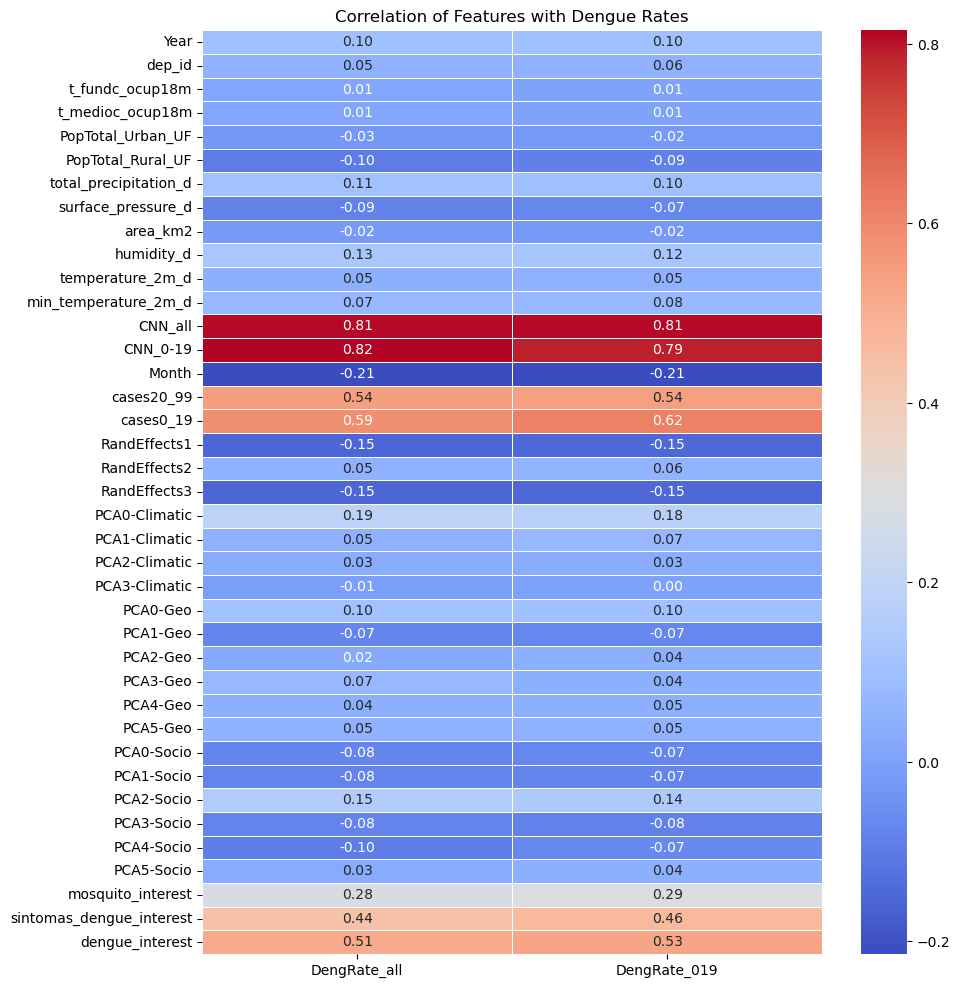

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute correlation matrix
corr_matrix = df.corr()

# Filter relevant correlations with dengue rates
dengue_corr = corr_matrix[['DengRate_all', 'DengRate_019']].drop(index=['DengRate_all', 'DengRate_019'])

# Plot heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(dengue_corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation of Features with Dengue Rates")
plt.show()


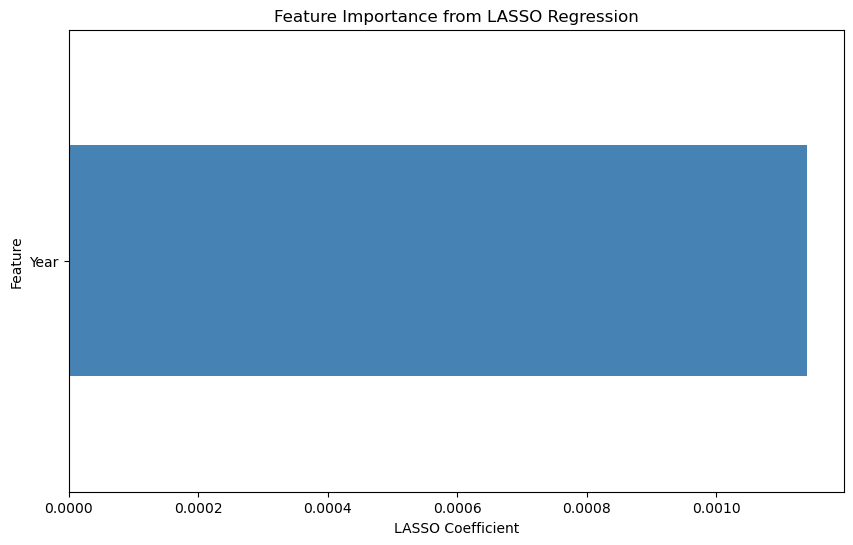

In [4]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# Preparing features and target variable
X = df.drop(columns=['DengRate_all', 'DengRate_019', 'dep_id'])  # Remove target and state ID
y = df['DengRate_all']

# # Standardize features for LASSO
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Apply LASSO for feature selection
lasso = Lasso(alpha=0.01)  # Regularization strength
lasso.fit(X, y)

# Extract feature importance
lasso_coeffs = pd.Series(lasso.coef_, index=X.columns)
lasso_coeffs = lasso_coeffs[lasso_coeffs != 0]  # Keep only non-zero coefficients

# Plot LASSO feature importance
plt.figure(figsize=(10, 6))
lasso_coeffs.sort_values().plot(kind='barh', color='steelblue')
plt.xlabel("LASSO Coefficient")
plt.ylabel("Feature")
plt.title("Feature Importance from LASSO Regression")
plt.show()


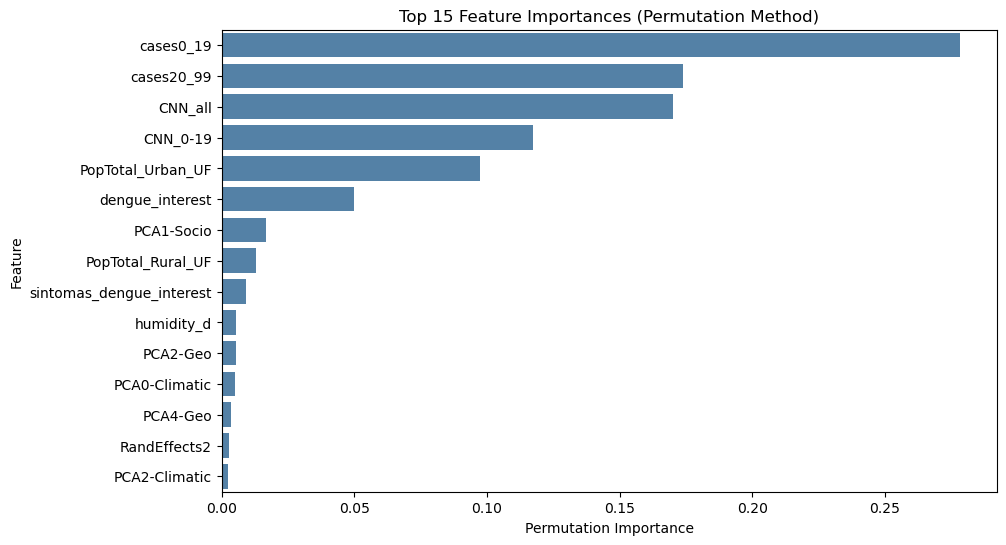

In [5]:
# Re-import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# Re-train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Compute permutation feature importance
perm_importance = permutation_importance(rf_model, X, y, n_repeats=10, random_state=42)

# Convert to DataFrame
perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(y=perm_importance_df["Feature"][:15], x=perm_importance_df["Importance"][:15], color="steelblue")
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Top 15 Feature Importances (Permutation Method)")
plt.show()


Cross-correlation for mosquito_interest


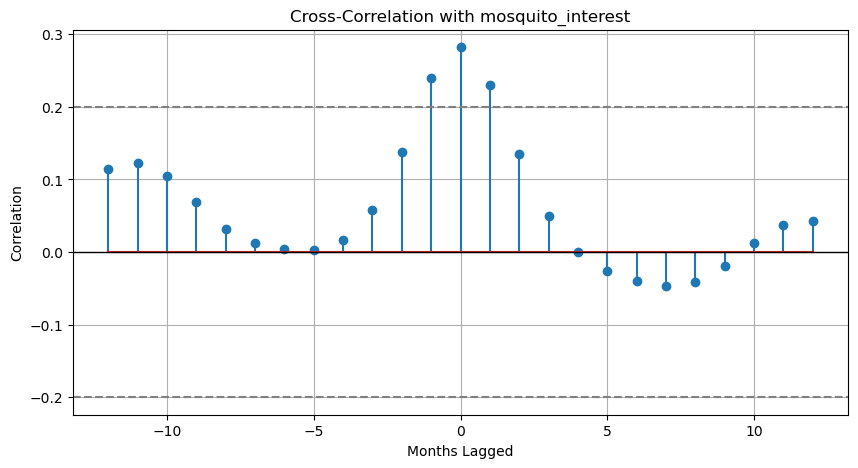

Cross-correlation for sintomas_dengue_interest


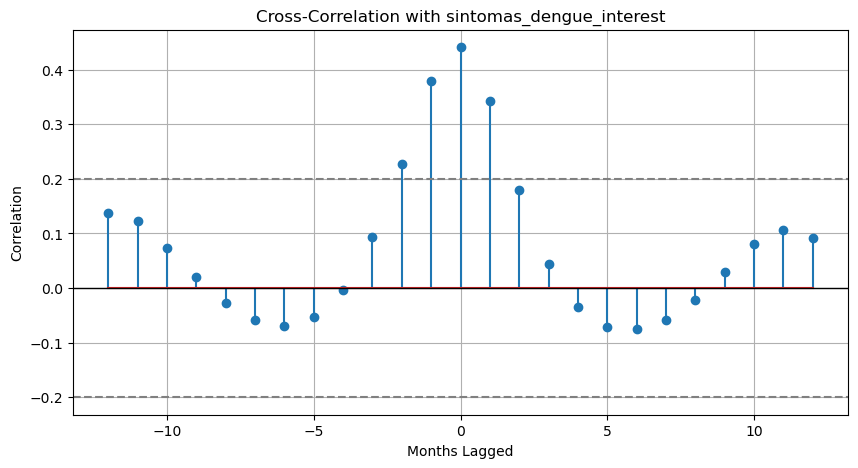

Cross-correlation for dengue_interest


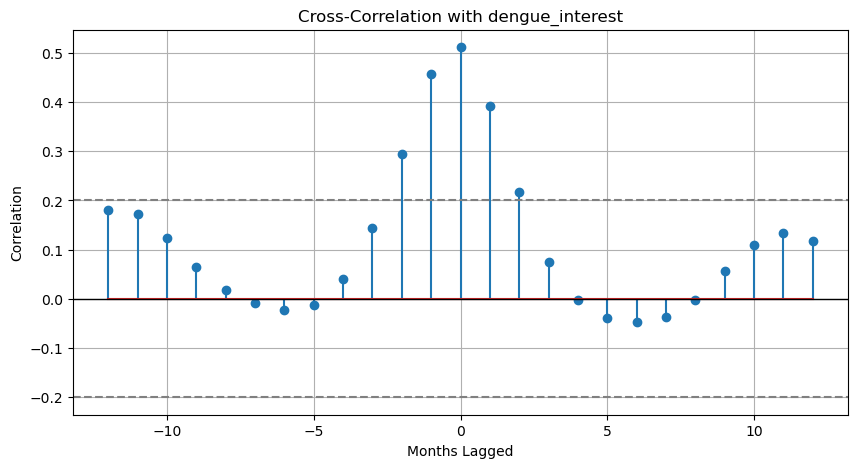


=== Granger Causality Test: mosquito_interest → DengRate_all ===

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2039  , p=0.6516  , df_denom=5180, df_num=1
ssr based chi2 test:   chi2=0.2040  , p=0.6515  , df=1
likelihood ratio test: chi2=0.2040  , p=0.6515  , df=1
parameter F test:         F=0.2039  , p=0.6516  , df_denom=5180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3536  , p=0.2584  , df_denom=5177, df_num=2
ssr based chi2 test:   chi2=2.7099  , p=0.2580  , df=2
likelihood ratio test: chi2=2.7092  , p=0.2581  , df=2
parameter F test:         F=1.3536  , p=0.2584  , df_denom=5177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8132  , p=0.1424  , df_denom=5174, df_num=3
ssr based chi2 test:   chi2=5.4468  , p=0.1419  , df=3
likelihood ratio test: chi2=5.4440  , p=0.1420  , df=3
parameter F test:         F=1.8132  , p=0.1424  , df_denom=5174, df_num=3

Granger Causality
num

C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Gautam\anaconda3\envs\minornew\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


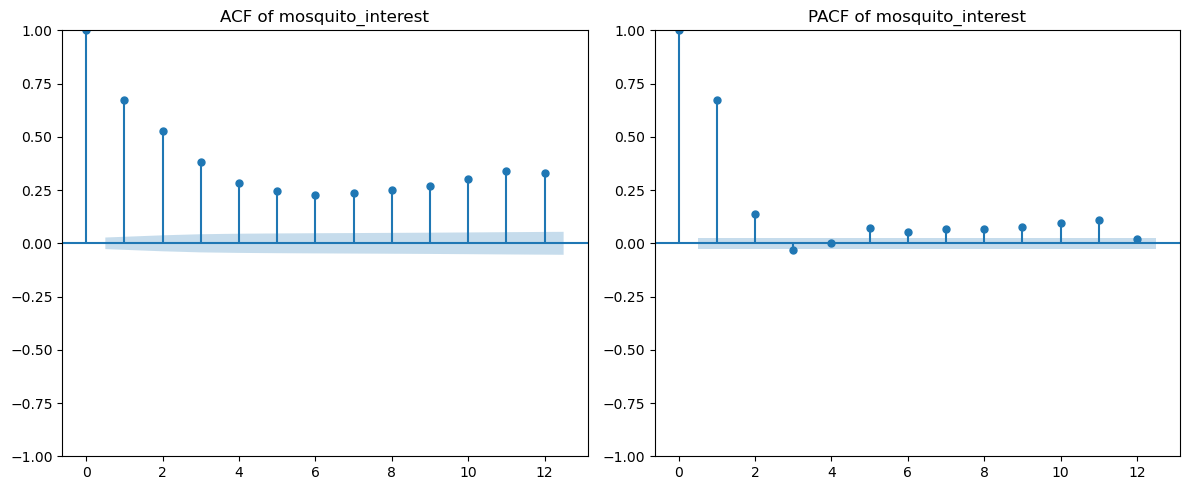


ACF/PACF for sintomas_dengue_interest


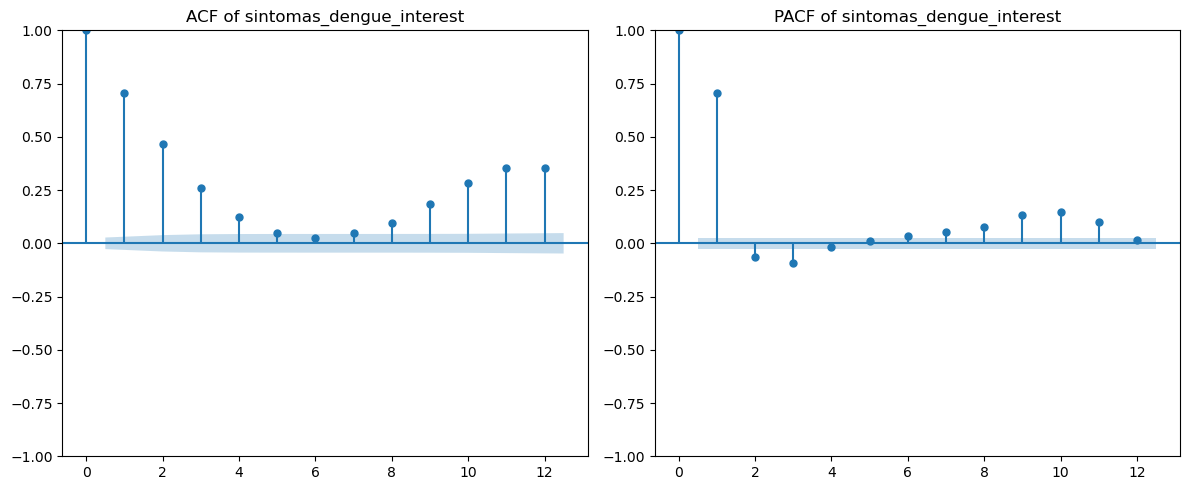


ACF/PACF for dengue_interest


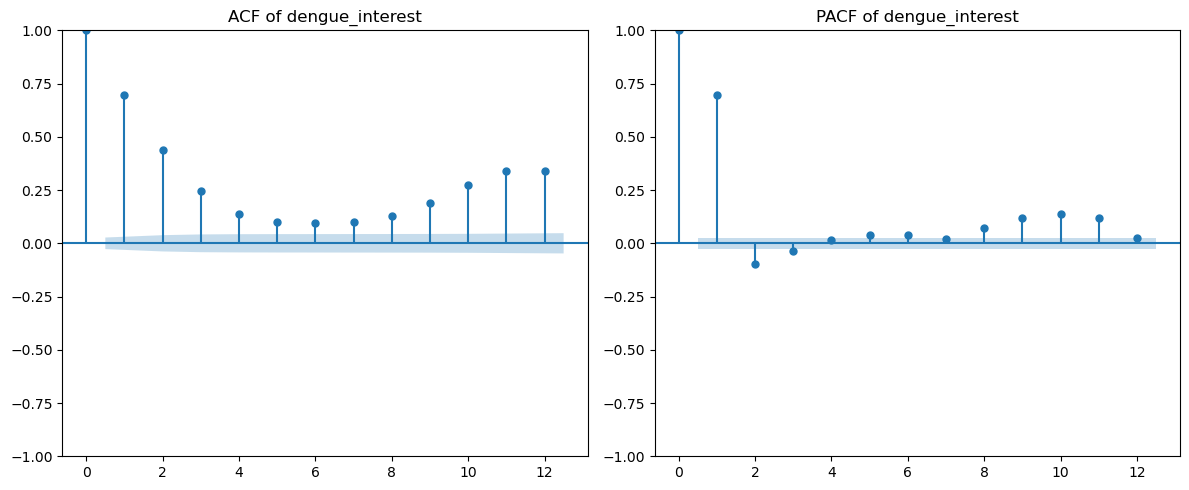

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests, acf, pacf
import statsmodels.api as sm

# Load dataset
file_path = "merged_dataset.csv"  # Update if needed
df = pd.read_csv(file_path)  # Adjust 'date_column'

# Ensure data is sorted by time
# df = df.sort_index()

# Columns for analysis
google_trends_cols = ['mosquito_interest', 'sintomas_dengue_interest', 'dengue_interest']
target_col = 'DengRate_all'  # Adjust to actual dengue cases column

### 1. CROSS-CORRELATION ANALYSIS (Find Best Lags/Leads) ###
def cross_correlation(series_x, series_y, max_lag=12):
    """Compute cross-correlation for lags (-max_lag to +max_lag)"""
    lags = range(-max_lag, max_lag + 1)
    correlations = [series_x.shift(lag).corr(series_y) for lag in lags]
    
    plt.figure(figsize=(10, 5))
    plt.stem(lags, correlations)  # Removed 'use_line_collection=True'
    plt.axhline(y=0, color='black', linewidth=1)
    plt.axhline(y=0.2, linestyle="--", color="gray")
    plt.axhline(y=-0.2, linestyle="--", color="gray")
    plt.title(f"Cross-Correlation with {series_x.name}")
    plt.xlabel("Months Lagged")
    plt.ylabel("Correlation")
    plt.grid()
    plt.show()


# Run Cross-Correlation for each Google Trends column
for col in google_trends_cols:
    print(f"Cross-correlation for {col}")
    cross_correlation(df[col], df[target_col])

### 2. GRANGER CAUSALITY TEST ###
def granger_test(df, max_lag=6):
    """Runs Granger Causality test for each Google Trends column"""
    for col in google_trends_cols:
        print(f"\n=== Granger Causality Test: {col} → {target_col} ===")
        test_result = grangercausalitytests(df[[target_col, col]], max_lag, verbose=True)
    
# Run Granger Causality Test
granger_test(df)

### 3. ACF/PACF ANALYSIS FOR GOOGLE TRENDS COLUMNS ###
def plot_acf_pacf(series, lags=12):
    """Plots ACF and PACF for a given series"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    sm.graphics.tsa.plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title(f"ACF of {series.name}")
    
    sm.graphics.tsa.plot_pacf(series, lags=lags, ax=axes[1])
    axes[1].set_title(f"PACF of {series.name}")
    
    plt.tight_layout()
    plt.show()

# Run ACF/PACF for each Google Trends column
for col in google_trends_cols:
    print(f"\nACF/PACF for {col}")
    plot_acf_pacf(df[col])


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load the dataset
file_path = "merged_dataset.csv"
df = pd.read_csv(file_path)

# Creating multiple lagged and lead versions of GT data
lags = [1, 2, 3]  # Months to shift backward
leads = [1, 2]  # Months to shift forward

gt_features = ['mosquito_interest', 'sintomas_dengue_interest', 'dengue_interest']

# # Apply lag
# for lag in lags:
#     for feature in gt_features:
#         df[f'{feature}_lag{lag}'] = df[feature].shift(lag)

# Apply lead
# df_lead=df
for lead in leads:
    df_lead=df.copy()
    for feature in gt_features:
        df_lead[f'{feature}_lead{lead}'] = df[feature].shift(-lead)  # Shift forward (future data)
    df_lead=df_lead.drop(columns=gt_features)

    # Define feature set with new lags and leads
    X_lag_lead = df_lead.drop(columns=['DengRate_all'])  # Keep all lag/lead GT features
    y = df_lead['DengRate_all']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_lag_lead, y, test_size=0.2, random_state=42)

    # Train model WITH all lag/lead features
    rf_model_with_lags = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model_with_lags.fit(X_train, y_train)
    y_pred_with_lags = rf_model_with_lags.predict(X_test)

    # Train model WITHOUT Google Trends (baseline)
    X_no_gt = df_lead.drop(columns=['DengRate_all']  + [f'{f}_lead{lead}' for f in gt_features])
    # X_no_gt_scaled = scaler.fit_transform(X_no_gt)

    X_train_no_gt, X_test_no_gt, y_train_no_gt, y_test_no_gt = train_test_split(X_no_gt, y, test_size=0.2, random_state=42)

    rf_model_no_gt = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model_no_gt.fit(X_train_no_gt, y_train_no_gt)
    y_pred_no_gt = rf_model_no_gt.predict(X_test_no_gt)

    # Compute errors
    mae_with_lags = mean_absolute_error(y_test, y_pred_with_lags)
    rmse_with_lags = np.sqrt(mean_squared_error(y_test, y_pred_with_lags))

    mae_no_gt = mean_absolute_error(y_test_no_gt, y_pred_no_gt)
    rmse_no_gt = np.sqrt(mean_squared_error(y_test_no_gt, y_pred_no_gt))

    # Print results
    print("Model Performance WITH Google Trends (Lags & Leads):")
    print(f"MAE: {mae_with_lags}lead:{lead}, RMSE: {rmse_with_lags}lead:{lead}")

    print("Model Performance WITHOUT Google Trends: ")
    print(f"MAE: {mae_no_gt}, RMSE: {rmse_no_gt}")

    # print(df_lead.columns)
    # print(df.columns)
    # df_lead=df_lead.drop(columns=[f'{f}_lead{lead}' for f in gt_features])

Model Performance WITH Google Trends (Lags & Leads):
MAE: 0.0031528871669646527lead:1, RMSE: 0.00959275916132887lead:1
Model Performance WITHOUT Google Trends: 
MAE: 0.003155947562089583, RMSE: 0.009545484838587429
Model Performance WITH Google Trends (Lags & Leads):
MAE: 0.0031670126564722328lead:2, RMSE: 0.00966771447351937lead:2
Model Performance WITHOUT Google Trends: 
MAE: 0.003155947562089583, RMSE: 0.009545484838587429


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Load the dataset
file_path = "merged_dataset.csv"
df = pd.read_csv(file_path)

# Creating multiple lagged and lead versions of GT data
lags = [1, 2, 3]  # Months to shift backward
leads = [1, 2]  # Months to shift forward

gt_features = ['mosquito_interest', 'sintomas_dengue_interest', 'dengue_interest']

# Apply lag
for lag in lags:
    df_lag=df.copy()
    for feature in gt_features:
        df_lag[f'{feature}_lag{lag}'] = df[feature].shift(lag)
    # df_lag=df_lag.drop(columns=gt_features)

    # Define feature set with new lags and leads
    X_lag_lag = df_lag.drop(columns=['DengRate_all'])  # Keep all lag/lag GT features
    y = df_lag['DengRate_all']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_lag_lag, y, test_size=0.2, random_state=42)

    # Train model WITH all lag/lag features
    rf_model_with_lags = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model_with_lags.fit(X_train, y_train)
    y_pred_with_lags = rf_model_with_lags.predict(X_test)

    # Train model WITHOUT Google Trends (baseline)
    X_no_gt = df_lag.drop(columns=['DengRate_all']  + [f'{f}_lag{lag}' for f in gt_features])
    # X_no_gt_scaled = scaler.fit_transform(X_no_gt)

    X_train_no_gt, X_test_no_gt, y_train_no_gt, y_test_no_gt = train_test_split(X_no_gt, y, test_size=0.2, random_state=42)

    rf_model_no_gt = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model_no_gt.fit(X_train_no_gt, y_train_no_gt)
    y_pred_no_gt = rf_model_no_gt.predict(X_test_no_gt)

    # Compute errors
    mae_with_lags = mean_absolute_error(y_test, y_pred_with_lags)
    rmse_with_lags = np.sqrt(mean_squared_error(y_test, y_pred_with_lags))

    mae_no_gt = mean_absolute_error(y_test_no_gt, y_pred_no_gt)
    rmse_no_gt = np.sqrt(mean_squared_error(y_test_no_gt, y_pred_no_gt))

    # Print results
    print("Model Performance WITH Google Trends (Lags & lags):")
    print(f"MAE: {mae_with_lags}lag:{lag}, RMSE: {rmse_with_lags}lag:{lag}")

    print("Model Performance WITHOUT Google Trends: ")
    print(f"MAE: {mae_no_gt}, RMSE: {rmse_no_gt}")

    # print(df_lead.columns)
    # print(df.columns)
    # df_lead=df_lead.drop(columns=[f'{f}_lead{lead}' for f in gt_features])

Model Performance WITH Google Trends (Lags & lags):
MAE: 0.003169191233733823lag:1, RMSE: 0.009796974024578955lag:1
Model Performance WITHOUT Google Trends: 
MAE: 0.003182080189827749, RMSE: 0.009764791952709505
Model Performance WITH Google Trends (Lags & lags):
MAE: 0.0032090072549657623lag:2, RMSE: 0.00984648656845699lag:2
Model Performance WITHOUT Google Trends: 
MAE: 0.003182080189827749, RMSE: 0.009764791952709505
Model Performance WITH Google Trends (Lags & lags):
MAE: 0.0031757758765723616lag:3, RMSE: 0.009756821675722718lag:3
Model Performance WITHOUT Google Trends: 
MAE: 0.003182080189827749, RMSE: 0.009764791952709505



=== Summary of Granger Causality Test Results ===
                 Feature  Min p-value  Best Lag Causality Found
                 CNN_all 0.000000e+00         1               ✅
                CNN_0-19 0.000000e+00         1               ✅
            RandEffects3 1.061242e-44        12               ✅
            RandEffects1 1.114098e-44        12               ✅
           PCA0-Climatic 2.027661e-36         5               ✅
              humidity_d 1.079643e-25         5               ✅
    min_temperature_2m_d 1.972916e-24         7               ✅
           PCA3-Climatic 9.915479e-23         7               ✅
   total_precipitation_d 5.232612e-18         6               ✅
        temperature_2m_d 6.182599e-18         7               ✅
           PCA1-Climatic 2.645605e-16         7               ✅
               cases0_19 7.896027e-13         4               ✅
      surface_pressure_d 9.010808e-13         6               ✅
            DengRate_019 3.410351e-11         4      

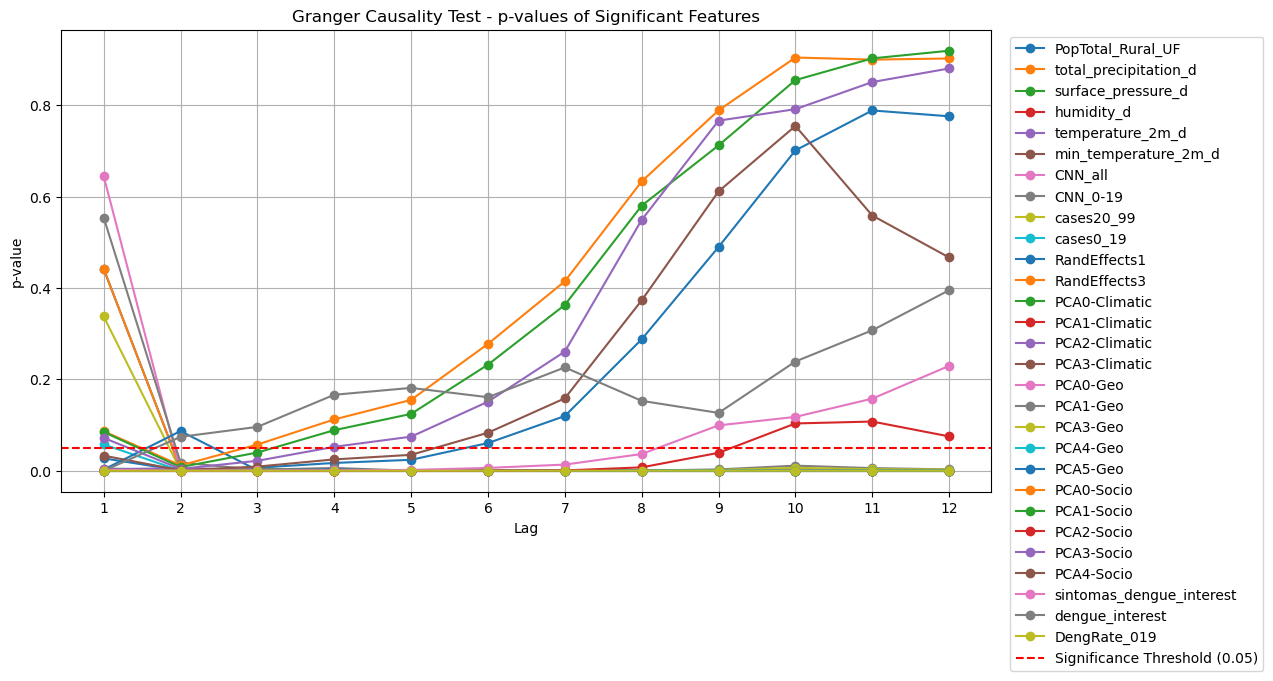

In [33]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

# Suppress warnings
warnings.filterwarnings("ignore")

# Define the target column and columns to exclude
target_col = 'DengRate_all'  # Adjust to your actual target column name
exclude_cols = ['Year', 'Month', 'dep_id']  # Columns to exclude

def granger_test(df, max_lag=12):
    """Runs Granger Causality test for all features except excluded columns and summarizes results."""
    
    features = [col for col in df.columns if col != target_col and col not in exclude_cols]
    results_summary = []

    all_p_values = {}  # Store p-values for visualization

    for col in features:
        test_result = grangercausalitytests(df[[target_col, col]], max_lag, verbose=False)
        
        # Extract p-values for each lag
        p_values = [test_result[lag][0]['ssr_chi2test'][1] for lag in range(1, max_lag + 1)]
        all_p_values[col] = p_values

        # Find the minimum p-value and corresponding lag
        min_p_value = min(p_values)
        best_lag = p_values.index(min_p_value) + 1  # Lags start from 1
        
        # Store results in summary list
        results_summary.append((col, min_p_value, best_lag, "✅" if min_p_value <= 0.05 else "❌"))

    # Convert to DataFrame for better readability
    results_df = pd.DataFrame(results_summary, columns=["Feature", "Min p-value", "Best Lag", "Causality Found"])
    results_df = results_df.sort_values(by="Min p-value")  # Sort by significance

    # Print summary table
    print("\n=== Summary of Granger Causality Test Results ===")
    print(results_df.to_string(index=False))

    # Plot: Keep only significant features for clarity
    significant_features = results_df[results_df["Min p-value"] <= 0.05]["Feature"].tolist()
    
    plt.figure(figsize=(12, 6))

    for col, p_vals in all_p_values.items():
        if col in significant_features:  # Plot only significant ones
            plt.plot(range(1, max_lag + 1), p_vals, marker='o', linestyle='-', label=col)

    plt.axhline(y=0.05, color='r', linestyle="--", label="Significance Threshold (0.05)")
    plt.xlabel("Lag")
    plt.ylabel("p-value")
    plt.title("Granger Causality Test - p-values of Significant Features")
    plt.xticks(range(1, max_lag + 1))
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))  # Move legend outside plot
    plt.grid()
    plt.show()

# Assuming df is your DataFrame containing the data
granger_test(df)



=== Cross-Correlation Summary ===
                 Feature  Max Correlation  Best Lag
            DengRate_019         0.982228         0
                CNN_0-19         0.928471         1
                 CNN_all         0.918401         1
               cases0_19         0.586183         0
              cases20_99         0.542118         0
         dengue_interest         0.511393         0
sintomas_dengue_interest         0.441092         0
       mosquito_interest         0.282021         0
              humidity_d        -0.236067        -5
           PCA0-Climatic         0.231153         1
            RandEffects3         0.219892         5
            RandEffects1         0.219627         5
   total_precipitation_d        -0.182050        -5
           PCA1-Climatic        -0.174050         5
           PCA3-Climatic         0.172109        -7
           PCA2-Climatic         0.167168        -5
              PCA2-Socio         0.149512        -2
                PCA0-Geo     

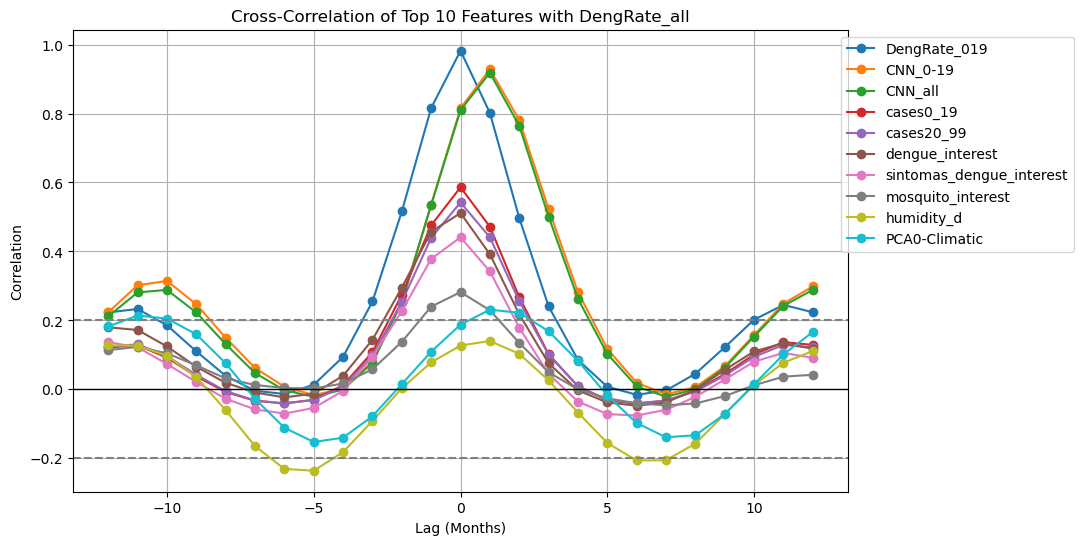

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Define target column and columns to exclude
target_col = 'DengRate_all'  # Adjust based on your dataset
exclude_cols = ['Year', 'Month', 'dep_id']  # Excluded columns

def cross_correlation_summary(df, max_lag=12, top_n=10):
    """Compute cross-correlation for all features against the target variable and summarize key findings."""
    
    # Select valid features (exclude target and other excluded columns)
    features = [col for col in df.columns if col != target_col and col not in exclude_cols]

    results_summary = []  # Store results for a summary table

    all_corr_values = {}  # Store correlations for visualization

    for col in features:
        lags = range(-max_lag, max_lag + 1)
        correlations = [df[col].shift(lag).corr(df[target_col]) for lag in lags]

        # Find the max absolute correlation and corresponding lag
        max_idx = max(range(len(correlations)), key=lambda x: abs(correlations[x]))
        max_corr = correlations[max_idx]
        max_lag_val = lags[max_idx]

        # Store results
        results_summary.append((col, max_corr, max_lag_val))
        all_corr_values[col] = correlations

    # Convert results to DataFrame and sort by absolute correlation strength
    results_df = pd.DataFrame(results_summary, columns=["Feature", "Max Correlation", "Best Lag"])
    results_df["Absolute Correlation"] = results_df["Max Correlation"].abs()
    results_df = results_df.sort_values(by="Absolute Correlation", ascending=False).drop(columns=["Absolute Correlation"])

    # Print summary table
    print("\n=== Cross-Correlation Summary ===")
    print(results_df.to_string(index=False))

    # Visualization: Only plot the **top N most correlated features**
    top_features = results_df.head(top_n)["Feature"].tolist()

    plt.figure(figsize=(10, 6))

    for col in top_features:
        lags = range(-max_lag, max_lag + 1)
        plt.plot(lags, all_corr_values[col], marker="o", linestyle="-", label=f"{col}")

    plt.axhline(y=0, color="black", linewidth=1)
    plt.axhline(y=0.2, linestyle="--", color="gray")
    plt.axhline(y=-0.2, linestyle="--", color="gray")

    plt.xlabel("Lag (Months)")
    plt.ylabel("Correlation")
    plt.title(f"Cross-Correlation of Top {top_n} Features with {target_col}")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
    plt.grid()
    plt.show()

# Run the function
cross_correlation_summary(df)


In [7]:
import pandas as pd
df=pd.read_csv('merged_dataset.csv')
# Define lags for each variable based on the must-do transformations
lags = {
    # 'DengRate_019': [1, 2, 3, 4],
    # 'cases0_19': [1, 2, 3, 4],
    # 'cases20_99': [1, 2, 3, 4],
    'CNN_all': [1],
    'CNN_0-19': [1],
    'humidity_d': [2,5],
    'min_temperature_2m_d': [7],
    'temperature_2m_d': [7],
    'total_precipitation_d': [3,5],
    'surface_pressure_d': [6],
    'PCA0-Climatic': [5],
    'PCA1-Climatic': [7],
    'PCA2-Climatic': [6],
    'PCA3-Climatic': [7],
    'dengue_interest': [1],
    'sintomas_dengue_interest': [2],
    # 'mosquito_interest': [7],
    'RandEffects1': [12],
    'RandEffects3': [12],
    'PopTotal_Rural_UF': [2],
    'PCA0-Geo': [7],
    'PCA1-Geo': [7],
    'PCA3-Geo': [6],
    'PCA4-Geo': [7],
    'PCA5-Geo': [7],
    'PCA0-Socio': [2],
    'PCA1-Socio': [2],
    'PCA2-Socio': [2],
    'PCA3-Socio': [2],
    'PCA4-Socio': [2]
}

# Create lagged features
def create_lags(df, lags):
    for col, lag_values in lags.items():
        if col in df.columns:
            for lag in lag_values:
                df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df

df = create_lags(df, lags)

# # Rolling Sum and Averages
# rolling_features = {
#     # 'DengRate_019': (3, 1),
#     # 'cases0_19': (3, 1),
#     # 'cases20_99': (3, 1),
#     'humidity_d': (3, 5),
#     'min_temperature_2m_d': (3, 7),
#     'temperature_2m_d': (3, 7),
#     'total_precipitation_d': (3, 6),
#     'surface_pressure_d': (3, 6),
#     'PCA0-Climatic': (3, 5),
#     'PCA1-Climatic': (3, 7),
#     'PCA2-Climatic': (3, 6),
#     'PCA3-Climatic': (3, 7)
# }

# def create_rolling_features(df, rolling_features):
#     for col, (window, lag) in rolling_features.items():
#         if col in df.columns:
#             df[f'{col}_roll{window}_lag{lag}'] = df[col].rolling(window).sum().shift(lag)
#     return df

# df = create_rolling_features(df, rolling_features)

# # Exponential Weighted Moving Averages (EWMA)
# ewma_features = {
#     'humidity_d': (0.7, 5),
#     'total_precipitation_d': (0.6, 6),
#     'dengue_interest': (0.8, 1),
#     'sintomas_dengue_interest': (0.8, 2),
#     'mosquito_interest': (0.7, 7)
# }

# def create_ewma(df, ewma_features):
#     for col, (alpha, lag) in ewma_features.items():
#         if col in df.columns:
#             df[f'{col}_ewma{alpha}_lag{lag}'] = df[col].ewm(alpha=alpha).mean().shift(lag)
#     return df

# df = create_ewma(df, ewma_features)

# Drop NaN values created due to shifting
# Ensure this is done after all transformations

df.dropna(inplace=True)
# Final dataset ready for model input
print(df.head(), df.shape)
df.to_csv('merged_dataset_lagged_noewma_norollavg.csv',index=False)


df.shape

    Year  dep_id  t_fundc_ocup18m  t_medioc_ocup18m  PopTotal_Urban_UF  \
12  2005      11         0.206751           0.12853           0.020497   
13  2005      11         0.206751           0.12853           0.020497   
14  2005      11         0.206751           0.12853           0.020497   
15  2005      11         0.206751           0.12853           0.020497   
16  2005      11         0.206751           0.12853           0.020497   

    PopTotal_Rural_UF  total_precipitation_d  surface_pressure_d  area_km2  \
12           0.089637               0.347706            0.799509  0.149352   
13           0.089637               0.406608            0.809708  0.149352   
14           0.089637               0.373682            0.818999  0.149352   
15           0.089637               0.133697            0.823006  0.149352   
16           0.089637               0.092777            0.821619  0.149352   

    humidity_d  ...  PCA0-Geo_lag7  PCA1-Geo_lag7  PCA3-Geo_lag6  \
12    0.906043  ..

(5172, 69)

In [21]:
import pandas as pd
import numpy as np

df=pd.read_csv('merged_dataset_lagged.csv')
# Reverse scaling of Month column (assuming original range was 1 to 12)
df['Month'] = (df.groupby(['Year']).cumcount() % 12 + 1)  # Generate month if not present

# Create a complete set of (dep_id, Year, Month) combinations for 2004-2019
import itertools

unique_dep_ids = df["dep_id"].unique()
years = list(range(2004, 2020))
months = list(range(1, 13))

expected_combinations = set(itertools.product(unique_dep_ids, years, months))

# Get existing (dep_id, Year, Month) combinations from the dataset
existing_combinations = set(zip(df["dep_id"], df["Year"], df["Month"]))

# Find missing combinations
missing_combinations = expected_combinations - existing_combinations

# Check if data exists for every dep_id for all months between 2004-2019
is_complete = len(missing_combinations) == 0

print(is_complete, len(missing_combinations), list(missing_combinations))  # Show first 10 missing entries if any


False 12 [(11, 2004, 5), (11, 2004, 11), (11, 2004, 1), (11, 2004, 4), (11, 2004, 10), (11, 2004, 7), (11, 2004, 3), (11, 2004, 6), (11, 2004, 9), (11, 2004, 12), (11, 2004, 2), (11, 2004, 8)]


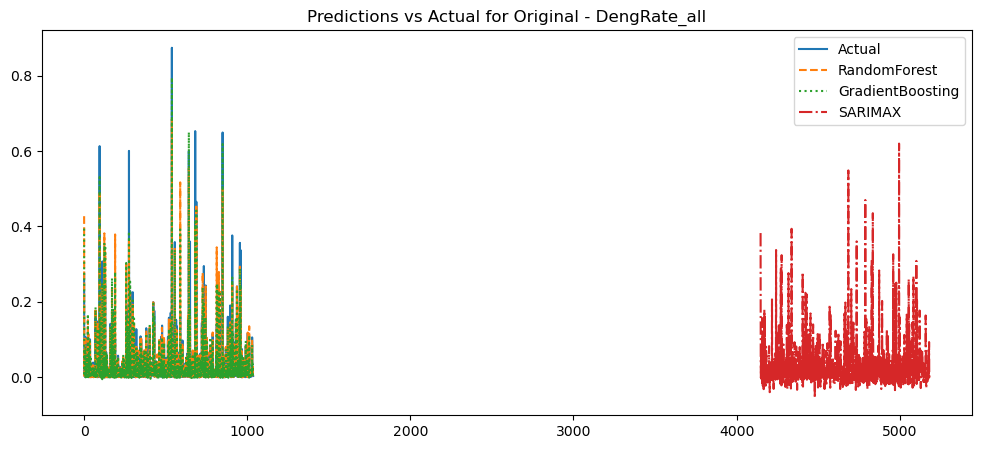

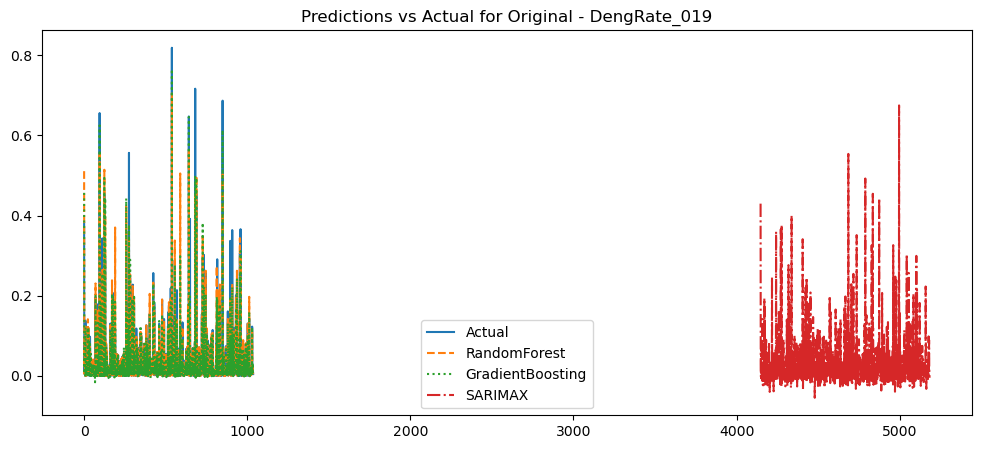

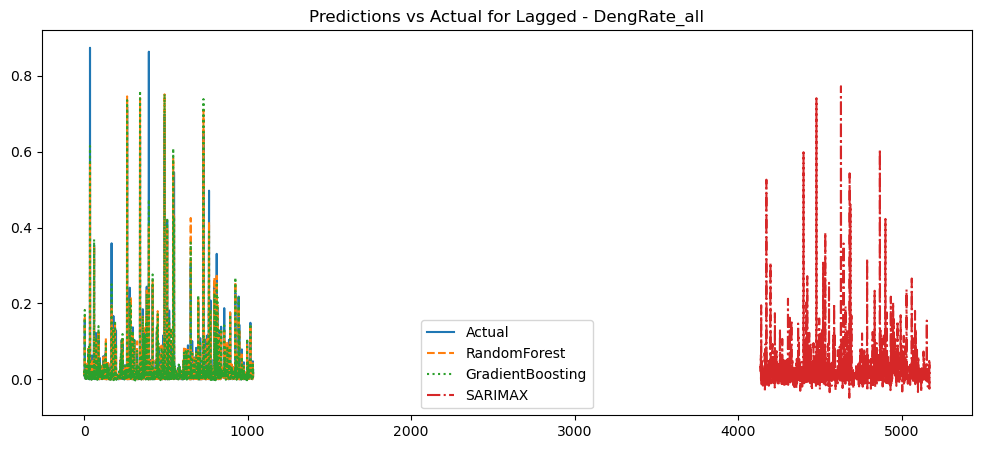

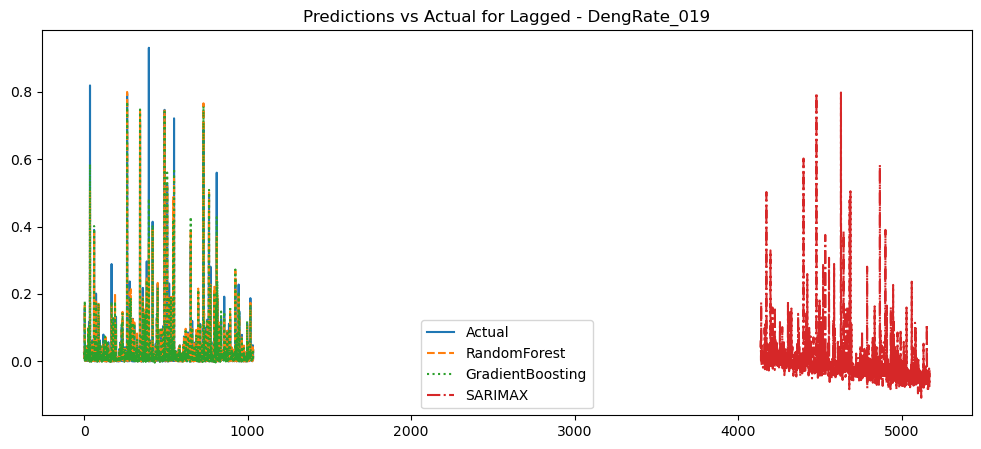

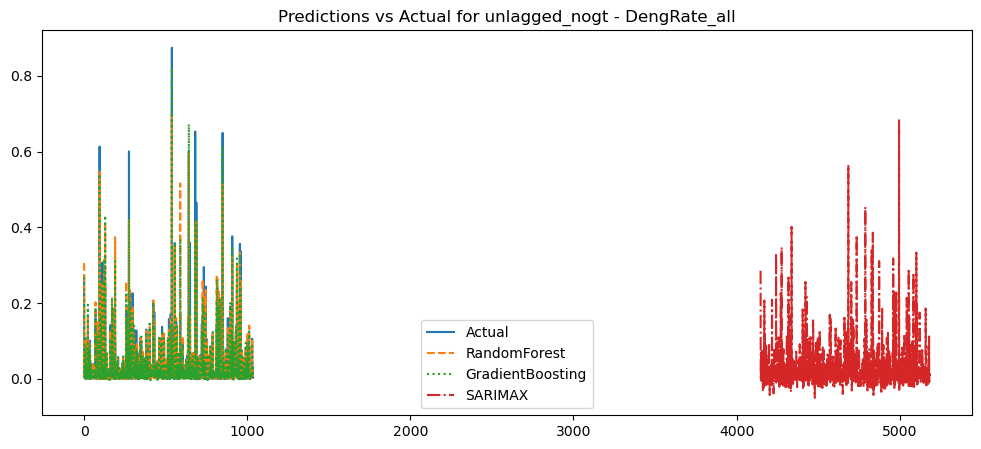

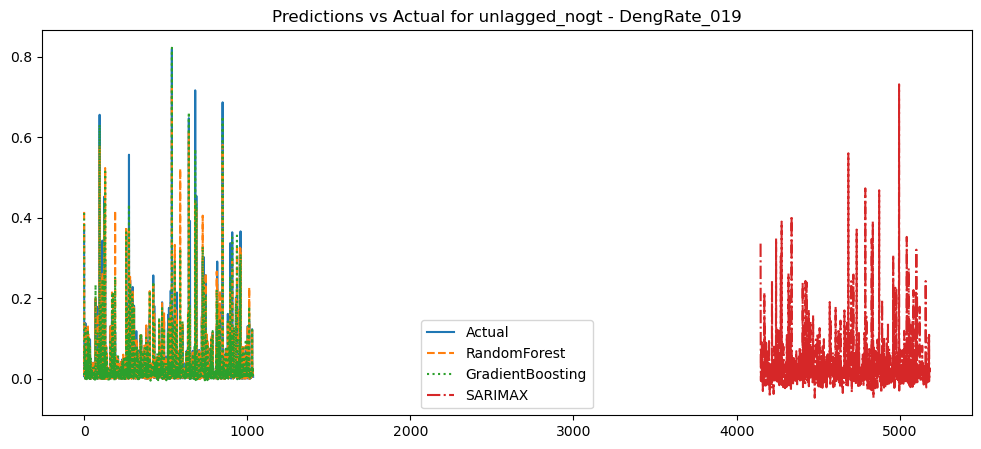


Results for Original_DengRate_all:
RandomForest: RMSE=0.0254, R²=0.8652, MAE=0.0053
GradientBoosting: RMSE=0.0203, R²=0.9134, MAE=0.0069
SARIMAX: RMSE=0.0375, R²=0.7049, MAE=0.0207

Results for Original_DengRate_019:
RandomForest: RMSE=0.0250, R²=0.8860, MAE=0.0052
GradientBoosting: RMSE=0.0185, R²=0.9373, MAE=0.0065
SARIMAX: RMSE=0.0378, R²=0.7395, MAE=0.0204

Results for Lagged_DengRate_all:
RandomForest: RMSE=0.0211, R²=0.9189, MAE=0.0043
GradientBoosting: RMSE=0.0190, R²=0.9340, MAE=0.0053
SARIMAX: RMSE=0.0291, R²=0.8455, MAE=0.0161

Results for Lagged_DengRate_019:
RandomForest: RMSE=0.0244, R²=0.9084, MAE=0.0044
GradientBoosting: RMSE=0.0196, R²=0.9410, MAE=0.0054
SARIMAX: RMSE=0.0493, R²=0.6260, MAE=0.0369

Results for unlagged_nogt_DengRate_all:
RandomForest: RMSE=0.0224, R²=0.8947, MAE=0.0046
GradientBoosting: RMSE=0.0190, R²=0.9245, MAE=0.0061
SARIMAX: RMSE=0.0364, R²=0.7229, MAE=0.0196

Results for unlagged_nogt_DengRate_019:
RandomForest: RMSE=0.0249, R²=0.8872, MAE=0.0047

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Load datasets
df_original = pd.read_csv("merged_dataset.csv")
df_lagged = pd.read_csv("merged_dataset_lagged.csv")
df_unlagged_nogt = df_original.drop(columns=['dengue_interest', 'sintomas_dengue_interest', 'mosquito_interest'])

# Define target variables
targets = ['DengRate_all', 'DengRate_019']

# Function to preprocess data
def preprocess_data(df, target):
    df = df.dropna()
    X = df.drop(columns=targets)  # Features
    y = df[target]  # Target variable
    
    # # Standardize features
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Function to train and evaluate models
def train_evaluate_models(X_train, X_test, y_train, y_test, dataset_name, target):
    results = {}
    
    # Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    results['RandomForest'] = (mean_squared_error(y_test, y_pred_rf, squared=False), r2_score(y_test, y_pred_rf), mean_absolute_error(y_test, y_pred_rf))
    
    # Gradient Boosting Regressor
    gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    gbr.fit(X_train, y_train)
    y_pred_gbr = gbr.predict(X_test)
    results['GradientBoosting'] = (mean_squared_error(y_test, y_pred_gbr, squared=False), r2_score(y_test, y_pred_gbr), mean_absolute_error(y_test, y_pred_gbr))
    
    # SARIMAX Model
    try:
        sarimax_model = SARIMAX(y_train, exog=X_train, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
        sarimax_fit = sarimax_model.fit(disp=False)
        y_pred_sarimax = sarimax_fit.forecast(steps=len(y_test), exog=X_test)
        results['SARIMAX'] = (mean_squared_error(y_test, y_pred_sarimax, squared=False), r2_score(y_test, y_pred_sarimax), mean_absolute_error(y_test, y_pred_sarimax))
    except Exception as e:
        print(f"SARIMAX failed for {dataset_name} - {target}: {e}")
        results['SARIMAX'] = (np.nan, np.nan, np.nan)
    
    # Visualization
    plt.figure(figsize=(12,5))
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred_rf, label='RandomForest', linestyle='dashed')
    plt.plot(y_pred_gbr, label='GradientBoosting', linestyle='dotted')
    if 'SARIMAX' in results and not np.isnan(results['SARIMAX'][0]):
        plt.plot(y_pred_sarimax, label='SARIMAX', linestyle='dashdot')
    plt.legend()
    plt.title(f'Predictions vs Actual for {dataset_name} - {target}')
    plt.show()
    
    return results

# Running models for both datasets
all_results = {}
for df, name in zip([df_original, df_lagged, df_unlagged_nogt], ["Original", "Lagged", "unlagged_nogt"]):
    for target in targets:
        X_train, X_test, y_train, y_test = preprocess_data(df, target)
        results = train_evaluate_models(X_train, X_test, y_train, y_test, name, target)
        all_results[f'{name}_{target}'] = results

# Print final results
for key, value in all_results.items():
    print(f"\nResults for {key}:")
    for model, scores in value.items():
        print(f"{model}: RMSE={scores[0]:.4f}, R²={scores[1]:.4f}, MAE={scores[2]:.4f}")

In [5]:
# Re-import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

file_path = "merged_dataset_lagged.csv"
df = pd.read_csv(file_path)
# Re-train the Random Forest model


# X = df.drop(columns=['DengRate_all', 'DengRate_019', 'dep_id'])  # Remove target and state ID
# y = df['DengRate_all']
targets = ['DengRate_all', 'DengRate_019']
X = df.drop(columns=targets)  # Features
y = df[target]  # Target variable
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Compute permutation feature importance
perm_importance = permutation_importance(rf_model, X, y, n_repeats=10, random_state=42)

# Convert to DataFrame
perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(y=perm_importance_df["Feature"][:15], x=perm_importance_df["Importance"][:30], color="steelblue")
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Top 15 Feature Importances (Permutation Method)")
plt.show()


NameError: name 'sns' is not defined

<Figure size 1000x600 with 0 Axes>

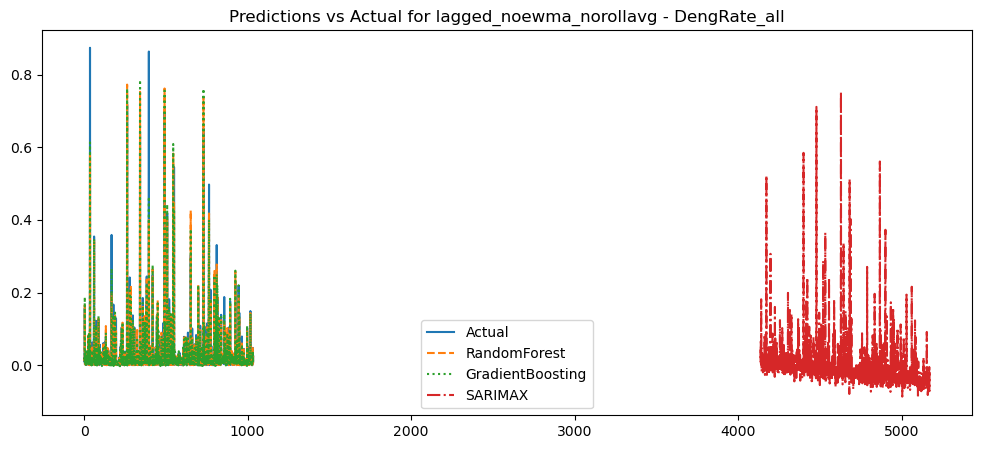

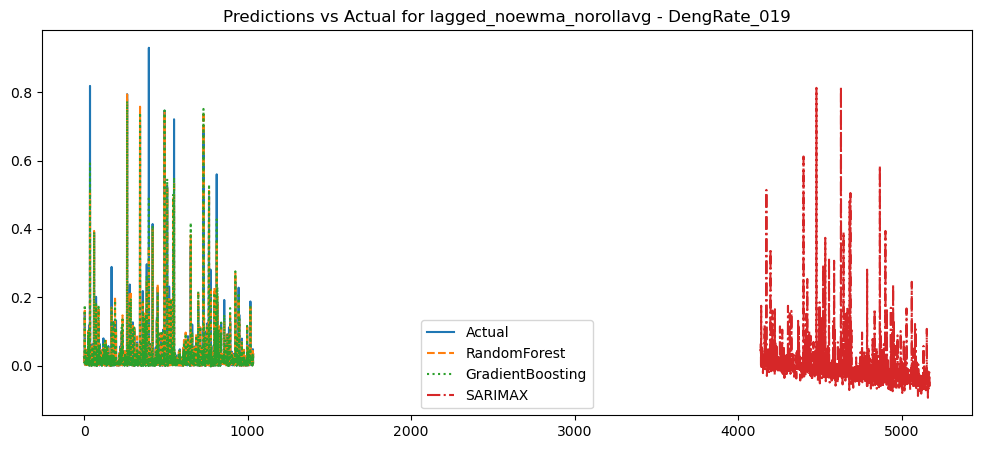


Results for lagged_noewma_norollavg_DengRate_all:
RandomForest: RMSE=0.0212, R²=0.9175, MAE=0.0043
GradientBoosting: RMSE=0.0194, R²=0.9311, MAE=0.0054
SARIMAX: RMSE=0.0426, R²=0.6682, MAE=0.0318

Results for lagged_noewma_norollavg_DengRate_019:
RandomForest: RMSE=0.0244, R²=0.9084, MAE=0.0043
GradientBoosting: RMSE=0.0198, R²=0.9396, MAE=0.0055
SARIMAX: RMSE=0.0467, R²=0.6643, MAE=0.0345


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Load datasets
# df_original = pd.read_csv("merged_dataset.csv")
df_lagged_noewma_norollavg = pd.read_csv("merged_dataset_lagged_noewma_norollavg.csv")
# df_unlagged_nogt = df_original.drop(columns=['dengue_interest', 'sintomas_dengue_interest', 'mosquito_interest'])

# Define target variables
targets = ['DengRate_all', 'DengRate_019']

# Function to preprocess data
def preprocess_data(df, target):
    df = df.dropna()
    X = df.drop(columns=targets)  # Features
    y = df[target]  # Target variable
    
    # # Standardize features
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Function to train and evaluate models
def train_evaluate_models(X_train, X_test, y_train, y_test, dataset_name, target):
    results = {}
    
    # Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    results['RandomForest'] = (mean_squared_error(y_test, y_pred_rf, squared=False), r2_score(y_test, y_pred_rf), mean_absolute_error(y_test, y_pred_rf))
    
    # Gradient Boosting Regressor
    gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    gbr.fit(X_train, y_train)
    y_pred_gbr = gbr.predict(X_test)
    results['GradientBoosting'] = (mean_squared_error(y_test, y_pred_gbr, squared=False), r2_score(y_test, y_pred_gbr), mean_absolute_error(y_test, y_pred_gbr))
    
    # SARIMAX Model
    try:
        sarimax_model = SARIMAX(y_train, exog=X_train, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
        sarimax_fit = sarimax_model.fit(disp=False)
        y_pred_sarimax = sarimax_fit.forecast(steps=len(y_test), exog=X_test)
        results['SARIMAX'] = (mean_squared_error(y_test, y_pred_sarimax, squared=False), r2_score(y_test, y_pred_sarimax), mean_absolute_error(y_test, y_pred_sarimax))
    except Exception as e:
        print(f"SARIMAX failed for {dataset_name} - {target}: {e}")
        results['SARIMAX'] = (np.nan, np.nan, np.nan)
    
    # Visualization
    plt.figure(figsize=(12,5))
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred_rf, label='RandomForest', linestyle='dashed')
    plt.plot(y_pred_gbr, label='GradientBoosting', linestyle='dotted')
    if 'SARIMAX' in results and not np.isnan(results['SARIMAX'][0]):
        plt.plot(y_pred_sarimax, label='SARIMAX', linestyle='dashdot')
    plt.legend()
    plt.title(f'Predictions vs Actual for {dataset_name} - {target}')
    plt.show()
    
    return results

# Running models for both datasets
all_results = {}
for df, name in zip([df_lagged_noewma_norollavg], ["lagged_noewma_norollavg"]):
    for target in targets:
        X_train, X_test, y_train, y_test = preprocess_data(df, target)
        results = train_evaluate_models(X_train, X_test, y_train, y_test, name, target)
        all_results[f'{name}_{target}'] = results

# Print final results
for key, value in all_results.items():
    print(f"\nResults for {key}:")
    for model, scores in value.items():
        print(f"{model}: RMSE={scores[0]:.4f}, R²={scores[1]:.4f}, MAE={scores[2]:.4f}")

In [9]:
import pandas as pd
df=pd.read_csv('merged_dataset.csv')
# Define lags for each variable based on the must-do transformations
lags = {
    # 'DengRate_019': [1, 2, 3, 4],
    # 'cases0_19': [1, 2, 3, 4],
    # 'cases20_99': [1, 2, 3, 4],
    'CNN_all': [1],
    'CNN_0-19': [1],
    'humidity_d': [2,5],
    'min_temperature_2m_d': [7],
    'temperature_2m_d': [7],
    'total_precipitation_d': [3,5],
    'surface_pressure_d': [6],
    'PCA0-Climatic': [5],
    'PCA1-Climatic': [7],
    'PCA2-Climatic': [6],
    'PCA3-Climatic': [7],
    'dengue_interest': [1],
    'sintomas_dengue_interest': [2],
    # 'mosquito_interest': [7],
    'RandEffects1': [12],
    'RandEffects3': [12],
    'PopTotal_Rural_UF': [2],
    'PCA0-Geo': [7],
    'PCA1-Geo': [7],
    'PCA3-Geo': [6],
    'PCA4-Geo': [7],
    'PCA5-Geo': [7],
    'PCA0-Socio': [2],
    'PCA1-Socio': [2],
    'PCA2-Socio': [2],
    'PCA3-Socio': [2],
    'PCA4-Socio': [2]
}

# Create lagged features
def create_lags(df, lags):
    for col, lag_values in lags.items():
        if col in df.columns:
            for lag in lag_values:
                df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df

df = create_lags(df, lags)

# Rolling Sum and Averages
rolling_features = {
    # 'DengRate_019': (3, 1),
    # 'cases0_19': (3, 1),
    # 'cases20_99': (3, 1),
    'humidity_d': (3, 5),
    'min_temperature_2m_d': (3, 7),
    'temperature_2m_d': (3, 7),
    'total_precipitation_d': (3, 6),
    'surface_pressure_d': (3, 6),
    'PCA0-Climatic': (3, 5),
    'PCA1-Climatic': (3, 7),
    'PCA2-Climatic': (3, 6),
    'PCA3-Climatic': (3, 7)
}

def create_rolling_features(df, rolling_features):
    for col, (window, lag) in rolling_features.items():
        if col in df.columns:
            df[f'{col}_roll{window}_lag{lag}'] = df[col].rolling(window).sum().shift(lag)
    return df

df = create_rolling_features(df, rolling_features)

# Exponential Weighted Moving Averages (EWMA)
ewma_features = {
    'humidity_d': (0.7, 5),
    'total_precipitation_d': (0.6, 6),
    'dengue_interest': (0.8, 1),
    'sintomas_dengue_interest': (0.8, 2),
    'mosquito_interest': (0.7, 7)
}

def create_ewma(df, ewma_features):
    for col, (alpha, lag) in ewma_features.items():
        if col in df.columns:
            df[f'{col}_ewma{alpha}_lag{lag}'] = df[col].ewm(alpha=alpha).mean().shift(lag)
    return df

df = create_ewma(df, ewma_features)

# Drop NaN values created due to shifting
# Ensure this is done after all transformations

df.dropna(inplace=True)
df=df.drop(columns=[
    'CNN_all',
    'CNN_0-19',
    'humidity_d',
    'min_temperature_2m_d',
    'temperature_2m_d',
    'total_precipitation_d',
    'surface_pressure_d',
    'PCA0-Climatic',
    'PCA1-Climatic',
    'PCA2-Climatic',
    'PCA3-Climatic',
    'dengue_interest',
    'sintomas_dengue_interest',
    'RandEffects1',
    'RandEffects3',
    'PopTotal_Rural_UF',
    'PCA0-Geo',
    'PCA1-Geo',
    'PCA3-Geo',
    'PCA4-Geo',
    'PCA5-Geo',
    'PCA0-Socio',
    'PCA1-Socio',
    'PCA2-Socio',
    'PCA3-Socio',
    'PCA4-Socio',
    'mosquito_interest'
]
)
# Final dataset ready for model input
print(df.head(), df.shape)
df.to_csv('merged_dataset_lagged_nooriginal.csv',index=False)

df.shape

    Year  dep_id  t_fundc_ocup18m  t_medioc_ocup18m  PopTotal_Urban_UF  \
12  2005      11         0.206751           0.12853           0.020497   
13  2005      11         0.206751           0.12853           0.020497   
14  2005      11         0.206751           0.12853           0.020497   
15  2005      11         0.206751           0.12853           0.020497   
16  2005      11         0.206751           0.12853           0.020497   

    area_km2     Month  cases20_99  cases0_19  RandEffects2  ...  \
12  0.149352  0.000000    0.007740   0.007527      0.000518  ...   
13  0.149352  0.090909    0.005108   0.006111      0.000518  ...   
14  0.149352  0.181818    0.003855   0.006249      0.000518  ...   
15  0.149352  0.272727    0.001228   0.002106      0.000518  ...   
16  0.149352  0.363636    0.000464   0.000621      0.000518  ...   

    surface_pressure_d_roll3_lag6  PCA0-Climatic_roll3_lag5  \
12                       2.520592                  2.260146   
13                  

(5172, 56)

In [10]:
import pandas as pd
df=pd.read_csv('merged_dataset.csv')
# Define lags for each variable based on the must-do transformations
lags = {
    # 'DengRate_019': [1, 2, 3, 4],
    # 'cases0_19': [1, 2, 3, 4],
    # 'cases20_99': [1, 2, 3, 4],
    'CNN_all': [1],
    'CNN_0-19': [1],
    'humidity_d': [2,5],
    'min_temperature_2m_d': [7],
    'temperature_2m_d': [7],
    'total_precipitation_d': [3,5],
    'surface_pressure_d': [6],
    'PCA0-Climatic': [5],
    'PCA1-Climatic': [7],
    'PCA2-Climatic': [6],
    'PCA3-Climatic': [7],
    'dengue_interest': [1],
    'sintomas_dengue_interest': [2],
    # 'mosquito_interest': [7],
    'RandEffects1': [12],
    'RandEffects3': [12],
    'PopTotal_Rural_UF': [2],
    'PCA0-Geo': [7],
    'PCA1-Geo': [7],
    'PCA3-Geo': [6],
    'PCA4-Geo': [7],
    'PCA5-Geo': [7],
    'PCA0-Socio': [2],
    'PCA1-Socio': [2],
    'PCA2-Socio': [2],
    'PCA3-Socio': [2],
    'PCA4-Socio': [2]
}

# Create lagged features
def create_lags(df, lags):
    for col, lag_values in lags.items():
        if col in df.columns:
            for lag in lag_values:
                df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df

df = create_lags(df, lags)

# # Rolling Sum and Averages
# rolling_features = {
#     # 'DengRate_019': (3, 1),
#     # 'cases0_19': (3, 1),
#     # 'cases20_99': (3, 1),
#     'humidity_d': (3, 5),
#     'min_temperature_2m_d': (3, 7),
#     'temperature_2m_d': (3, 7),
#     'total_precipitation_d': (3, 6),
#     'surface_pressure_d': (3, 6),
#     'PCA0-Climatic': (3, 5),
#     'PCA1-Climatic': (3, 7),
#     'PCA2-Climatic': (3, 6),
#     'PCA3-Climatic': (3, 7)
# }

# def create_rolling_features(df, rolling_features):
#     for col, (window, lag) in rolling_features.items():
#         if col in df.columns:
#             df[f'{col}_roll{window}_lag{lag}'] = df[col].rolling(window).sum().shift(lag)
#     return df

# df = create_rolling_features(df, rolling_features)

# # Exponential Weighted Moving Averages (EWMA)
# ewma_features = {
#     'humidity_d': (0.7, 5),
#     'total_precipitation_d': (0.6, 6),
#     'dengue_interest': (0.8, 1),
#     'sintomas_dengue_interest': (0.8, 2),
#     'mosquito_interest': (0.7, 7)
# }

# def create_ewma(df, ewma_features):
#     for col, (alpha, lag) in ewma_features.items():
#         if col in df.columns:
#             df[f'{col}_ewma{alpha}_lag{lag}'] = df[col].ewm(alpha=alpha).mean().shift(lag)
#     return df

# df = create_ewma(df, ewma_features)

# Drop NaN values created due to shifting
# Ensure this is done after all transformations

df.dropna(inplace=True)
df=df.drop(columns=[
    'CNN_all',
    'CNN_0-19',
    'humidity_d',
    'min_temperature_2m_d',
    'temperature_2m_d',
    'total_precipitation_d',
    'surface_pressure_d',
    'PCA0-Climatic',
    'PCA1-Climatic',
    'PCA2-Climatic',
    'PCA3-Climatic',
    'dengue_interest',
    'sintomas_dengue_interest',
    'RandEffects1',
    'RandEffects3',
    'PopTotal_Rural_UF',
    'PCA0-Geo',
    'PCA1-Geo',
    'PCA3-Geo',
    'PCA4-Geo',
    'PCA5-Geo',
    'PCA0-Socio',
    'PCA1-Socio',
    'PCA2-Socio',
    'PCA3-Socio',
    'PCA4-Socio',
    # 'mosquito_interest'
]
)
# Final dataset ready for model input
print(df.head(), df.shape)
df.to_csv('merged_dataset_lagged_noewma_norollavg_nooriginal.csv',index=False)

df.shape

    Year  dep_id  t_fundc_ocup18m  t_medioc_ocup18m  PopTotal_Urban_UF  \
12  2005      11         0.206751           0.12853           0.020497   
13  2005      11         0.206751           0.12853           0.020497   
14  2005      11         0.206751           0.12853           0.020497   
15  2005      11         0.206751           0.12853           0.020497   
16  2005      11         0.206751           0.12853           0.020497   

    area_km2     Month  cases20_99  cases0_19  RandEffects2  ...  \
12  0.149352  0.000000    0.007740   0.007527      0.000518  ...   
13  0.149352  0.090909    0.005108   0.006111      0.000518  ...   
14  0.149352  0.181818    0.003855   0.006249      0.000518  ...   
15  0.149352  0.272727    0.001228   0.002106      0.000518  ...   
16  0.149352  0.363636    0.000464   0.000621      0.000518  ...   

    PCA0-Geo_lag7  PCA1-Geo_lag7  PCA3-Geo_lag6  PCA4-Geo_lag7  PCA5-Geo_lag7  \
12       0.465208       0.271718       0.575990       0.396563   

(5172, 43)

In [11]:
import pandas as pd
df=pd.read_csv('merged_dataset.csv')
# Define lags for each variable based on the must-do transformations
lags = {
    # 'DengRate_019': [1, 2, 3, 4],
    # 'cases0_19': [1, 2, 3, 4],
    # 'cases20_99': [1, 2, 3, 4],
    # 'CNN_all': [1],
    # 'CNN_0-19': [1],
    # 'humidity_d': [2,5],
    # 'min_temperature_2m_d': [7],
    # 'temperature_2m_d': [7],
    # 'total_precipitation_d': [3,5],
    # 'surface_pressure_d': [6],
    # 'PCA0-Climatic': [5],
    # 'PCA1-Climatic': [7],
    # 'PCA2-Climatic': [6],
    # 'PCA3-Climatic': [7],
    'dengue_interest': [1],
    'sintomas_dengue_interest': [2],
    # # 'mosquito_interest': [7],
    # 'RandEffects1': [12],
    # 'RandEffects3': [12],
    # 'PopTotal_Rural_UF': [2],
    # 'PCA0-Geo': [7],
    # 'PCA1-Geo': [7],
    # 'PCA3-Geo': [6],
    # 'PCA4-Geo': [7],
    # 'PCA5-Geo': [7],
    # 'PCA0-Socio': [2],
    # 'PCA1-Socio': [2],
    # 'PCA2-Socio': [2],
    # 'PCA3-Socio': [2],
    # 'PCA4-Socio': [2]
}

# Create lagged features
def create_lags(df, lags):
    for col, lag_values in lags.items():
        if col in df.columns:
            for lag in lag_values:
                df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df

df = create_lags(df, lags)

# # Rolling Sum and Averages
# rolling_features = {
#     # 'DengRate_019': (3, 1),
#     # 'cases0_19': (3, 1),
#     # 'cases20_99': (3, 1),
#     'humidity_d': (3, 5),
#     'min_temperature_2m_d': (3, 7),
#     'temperature_2m_d': (3, 7),
#     'total_precipitation_d': (3, 6),
#     'surface_pressure_d': (3, 6),
#     'PCA0-Climatic': (3, 5),
#     'PCA1-Climatic': (3, 7),
#     'PCA2-Climatic': (3, 6),
#     'PCA3-Climatic': (3, 7)
# }

# def create_rolling_features(df, rolling_features):
#     for col, (window, lag) in rolling_features.items():
#         if col in df.columns:
#             df[f'{col}_roll{window}_lag{lag}'] = df[col].rolling(window).sum().shift(lag)
#     return df

# df = create_rolling_features(df, rolling_features)

# # Exponential Weighted Moving Averages (EWMA)
# ewma_features = {
#     'humidity_d': (0.7, 5),
#     'total_precipitation_d': (0.6, 6),
#     'dengue_interest': (0.8, 1),
#     'sintomas_dengue_interest': (0.8, 2),
#     'mosquito_interest': (0.7, 7)
# }

# def create_ewma(df, ewma_features):
#     for col, (alpha, lag) in ewma_features.items():
#         if col in df.columns:
#             df[f'{col}_ewma{alpha}_lag{lag}'] = df[col].ewm(alpha=alpha).mean().shift(lag)
#     return df

# df = create_ewma(df, ewma_features)

# Drop NaN values created due to shifting
# Ensure this is done after all transformations

df.dropna(inplace=True)

# Final dataset ready for model input
print(df.head(), df.shape)
df.to_csv('merged_dataset_lagged_gtonly.csv',index=False)

df.shape

   Year  dep_id  t_fundc_ocup18m  t_medioc_ocup18m  PopTotal_Urban_UF  \
2  2004      11         0.206751           0.12853           0.020497   
3  2004      11         0.206751           0.12853           0.020497   
4  2004      11         0.206751           0.12853           0.020497   
5  2004      11         0.206751           0.12853           0.020497   
6  2004      11         0.206751           0.12853           0.020497   

   PopTotal_Rural_UF  total_precipitation_d  surface_pressure_d  area_km2  \
2           0.089637               0.419033            0.812810  0.149352   
3           0.089637               0.261944            0.817030  0.149352   
4           0.089637               0.104751            0.837945  0.149352   
5           0.089637               0.044016            0.847697  0.149352   
6           0.089637               0.037815            0.834950  0.149352   

   humidity_d  ...  PCA3-Socio  PCA4-Socio  PCA5-Socio  mosquito_interest  \
2    0.953611  ...   

(5182, 43)

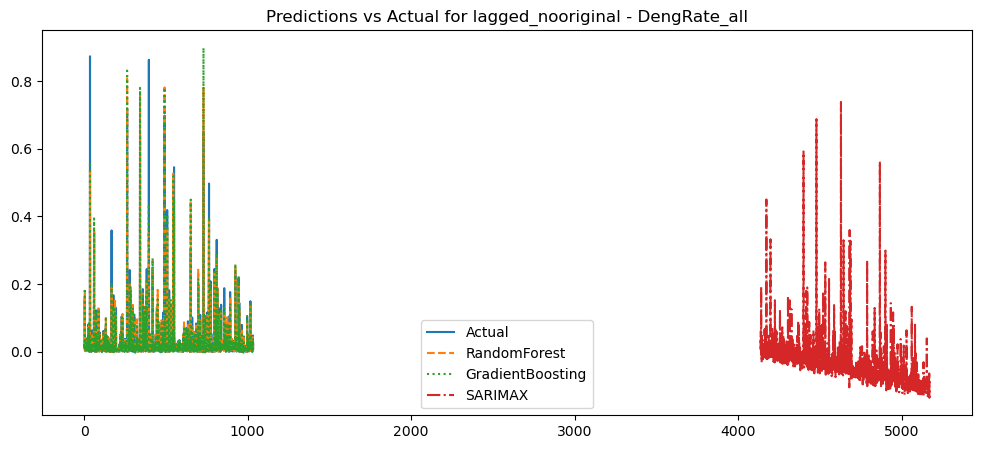

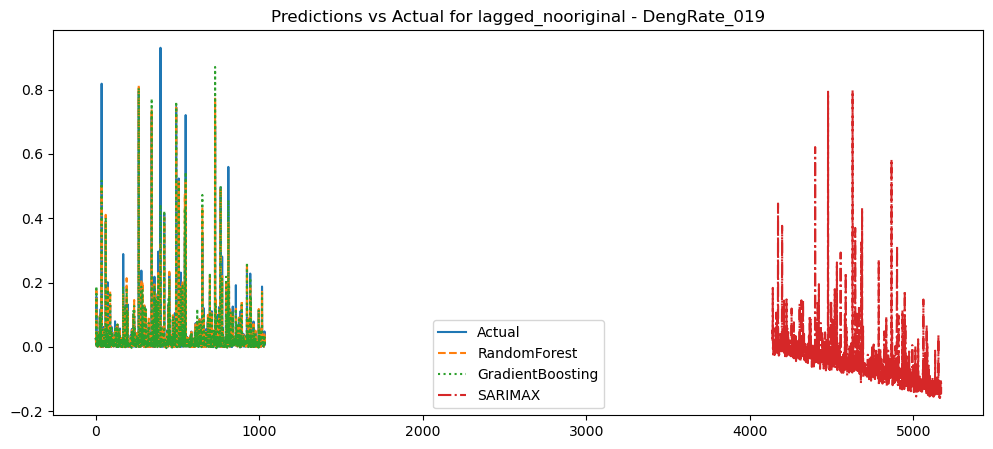

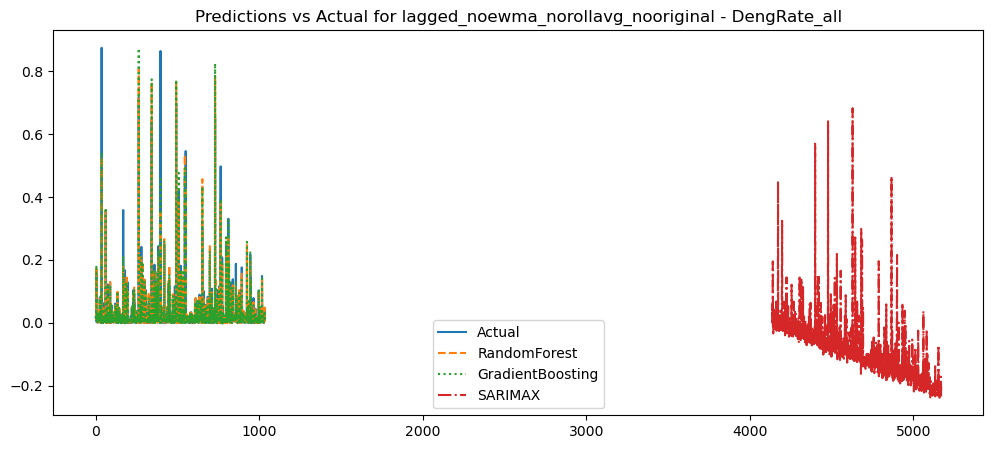

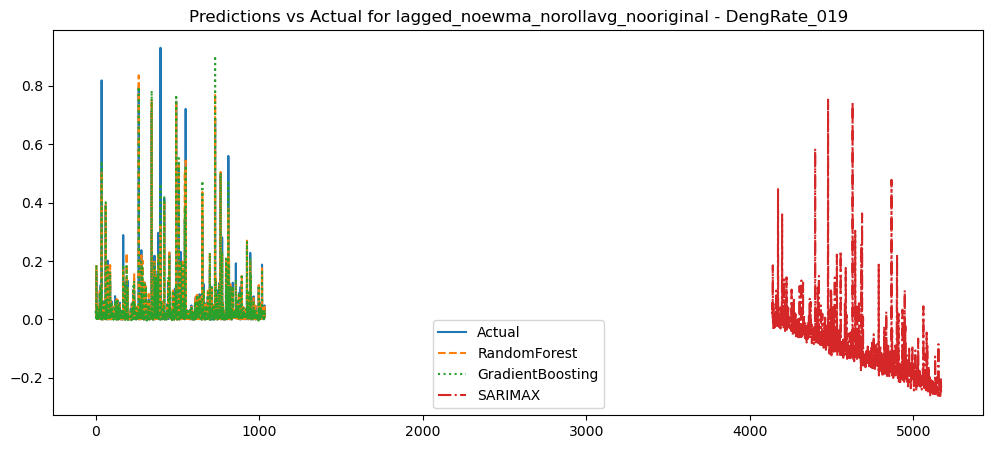

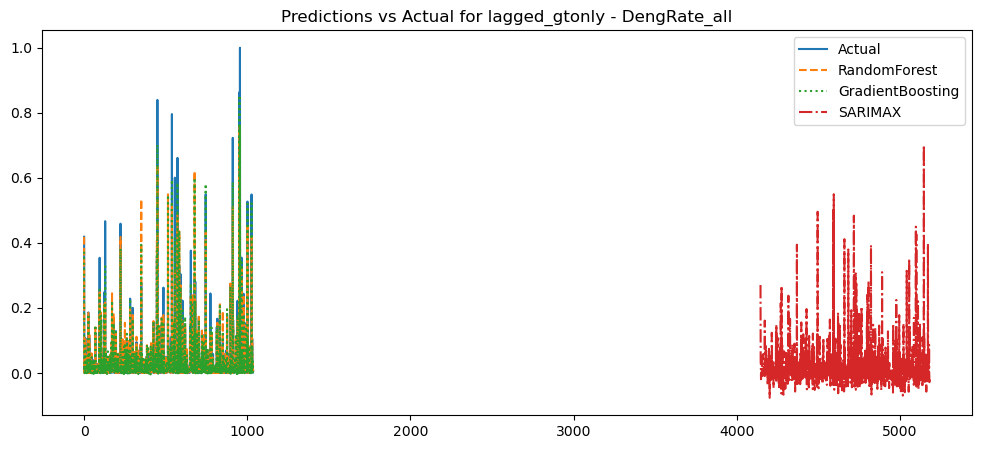

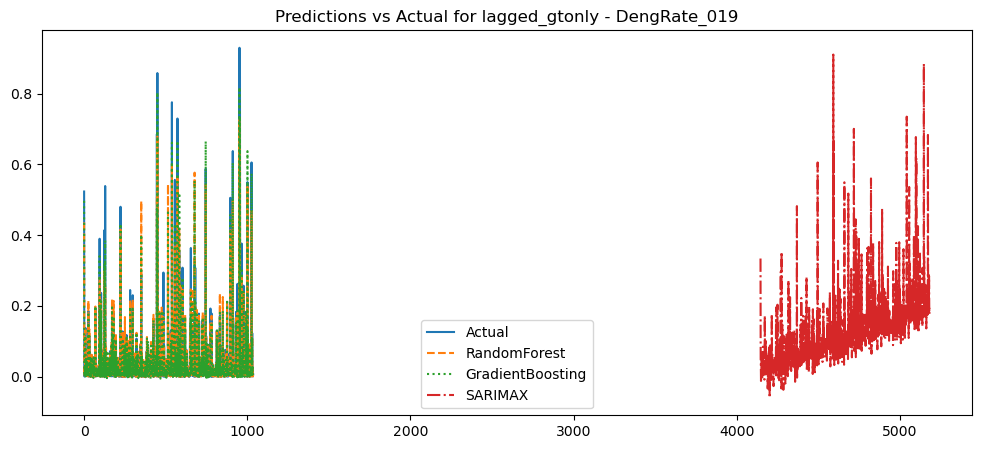


Results for lagged_nooriginal_DengRate_all:
RandomForest: RMSE=0.0236, R²=0.8980, MAE=0.0046
GradientBoosting: RMSE=0.0222, R²=0.9097, MAE=0.0056
SARIMAX: RMSE=0.0758, R²=-0.0501, MAE=0.0626

Results for lagged_nooriginal_DengRate_019:
RandomForest: RMSE=0.0254, R²=0.9009, MAE=0.0044
GradientBoosting: RMSE=0.0223, R²=0.9232, MAE=0.0056
SARIMAX: RMSE=0.0901, R²=-0.2494, MAE=0.0752

Results for lagged_noewma_norollavg_nooriginal_DengRate_all:
RandomForest: RMSE=0.0236, R²=0.8985, MAE=0.0045
GradientBoosting: RMSE=0.0217, R²=0.9142, MAE=0.0055
SARIMAX: RMSE=0.1353, R²=-2.3429, MAE=0.1157

Results for lagged_noewma_norollavg_nooriginal_DengRate_019:
RandomForest: RMSE=0.0254, R²=0.9010, MAE=0.0044
GradientBoosting: RMSE=0.0216, R²=0.9283, MAE=0.0054
SARIMAX: RMSE=0.1523, R²=-2.5699, MAE=0.1307

Results for lagged_gtonly_DengRate_all:
RandomForest: RMSE=0.0309, R²=0.8726, MAE=0.0065
GradientBoosting: RMSE=0.0231, R²=0.9290, MAE=0.0071
SARIMAX: RMSE=0.0483, R²=0.6887, MAE=0.0258

Results fo

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Load datasets
# df_original = pd.read_csv("merged_dataset.csv")
df_lagged_nooriginal = pd.read_csv("merged_dataset_lagged_nooriginal.csv")
df_lagged_noewma_norollavg_nooriginal = pd.read_csv("merged_dataset_lagged_noewma_norollavg_nooriginal.csv")
df_lagged_gtonly = pd.read_csv("merged_dataset_lagged_gtonly.csv")

# Define target variables
targets = ['DengRate_all', 'DengRate_019']

# Function to preprocess data
def preprocess_data(df, target):
    df = df.dropna()
    X = df.drop(columns=targets)  # Features
    y = df[target]  # Target variable
    
    # # Standardize features
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Function to train and evaluate models
def train_evaluate_models(X_train, X_test, y_train, y_test, dataset_name, target):
    results = {}
    
    # Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    results['RandomForest'] = (mean_squared_error(y_test, y_pred_rf, squared=False), r2_score(y_test, y_pred_rf), mean_absolute_error(y_test, y_pred_rf))
    
    # Gradient Boosting Regressor
    gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    gbr.fit(X_train, y_train)
    y_pred_gbr = gbr.predict(X_test)
    results['GradientBoosting'] = (mean_squared_error(y_test, y_pred_gbr, squared=False), r2_score(y_test, y_pred_gbr), mean_absolute_error(y_test, y_pred_gbr))
    
    # SARIMAX Model
    try:
        sarimax_model = SARIMAX(y_train, exog=X_train, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
        sarimax_fit = sarimax_model.fit(disp=False)
        y_pred_sarimax = sarimax_fit.forecast(steps=len(y_test), exog=X_test)
        results['SARIMAX'] = (mean_squared_error(y_test, y_pred_sarimax, squared=False), r2_score(y_test, y_pred_sarimax), mean_absolute_error(y_test, y_pred_sarimax))
    except Exception as e:
        print(f"SARIMAX failed for {dataset_name} - {target}: {e}")
        results['SARIMAX'] = (np.nan, np.nan, np.nan)
    
    # Visualization
    plt.figure(figsize=(12,5))
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred_rf, label='RandomForest', linestyle='dashed')
    plt.plot(y_pred_gbr, label='GradientBoosting', linestyle='dotted')
    if 'SARIMAX' in results and not np.isnan(results['SARIMAX'][0]):
        plt.plot(y_pred_sarimax, label='SARIMAX', linestyle='dashdot')
    plt.legend()
    plt.title(f'Predictions vs Actual for {dataset_name} - {target}')
    plt.show()
    
    return results

# Running models for both datasets
all_results = {}
for df, name in zip([df_lagged_nooriginal,df_lagged_noewma_norollavg_nooriginal,df_lagged_gtonly], ["lagged_nooriginal","lagged_noewma_norollavg_nooriginal","lagged_gtonly"]):
    for target in targets:
        X_train, X_test, y_train, y_test = preprocess_data(df, target)
        results = train_evaluate_models(X_train, X_test, y_train, y_test, name, target)
        all_results[f'{name}_{target}'] = results

# Print final results
for key, value in all_results.items():
    print(f"\nResults for {key}:")
    for model, scores in value.items():
        print(f"{model}: RMSE={scores[0]:.4f}, R²={scores[1]:.4f}, MAE={scores[2]:.4f}")

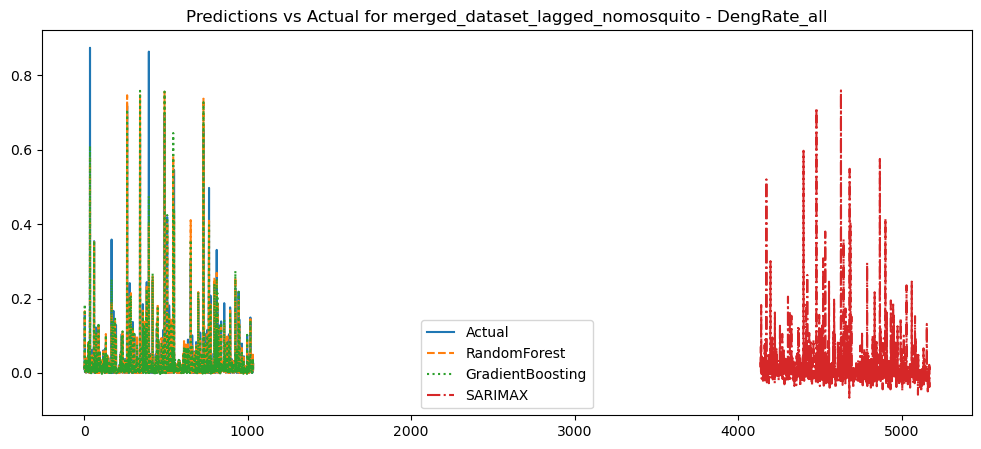

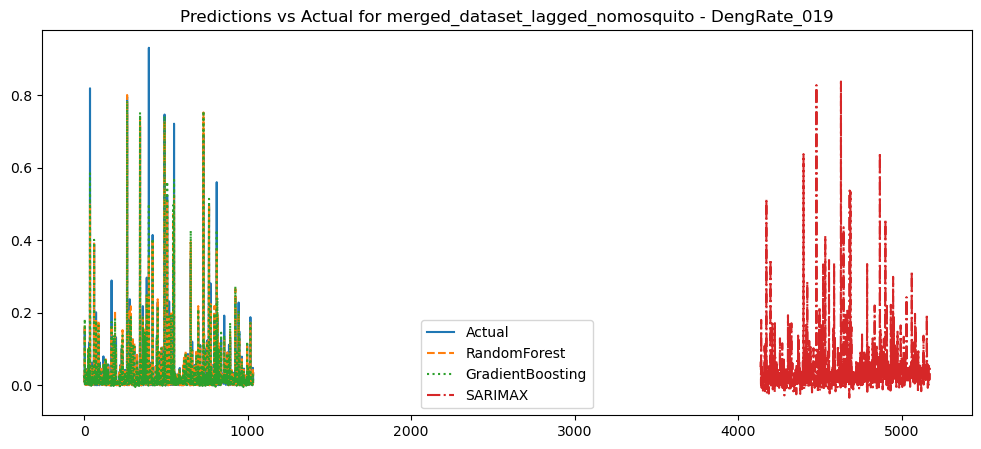


Results for merged_dataset_lagged_nomosquito_DengRate_all:
RandomForest: RMSE=0.0212, R²=0.9178, MAE=0.0043
GradientBoosting: RMSE=0.0192, R²=0.9327, MAE=0.0053
SARIMAX: RMSE=0.0309, R²=0.8250, MAE=0.0184

Results for merged_dataset_lagged_nomosquito_DengRate_019:
RandomForest: RMSE=0.0245, R²=0.9080, MAE=0.0044
GradientBoosting: RMSE=0.0198, R²=0.9396, MAE=0.0056
SARIMAX: RMSE=0.0338, R²=0.8241, MAE=0.0204


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Load datasets
# df_original = pd.read_csv("merged_dataset.csv")
df_lagged_nomosquito = pd.read_csv("merged_dataset_lagged.csv")
df_lagged_nomosquito=df_lagged_nomosquito.drop(columns=['dengue_interest'])

# Define target variables
targets = ['DengRate_all', 'DengRate_019']

# Function to preprocess data
def preprocess_data(df, target):
    df = df.dropna()
    X = df.drop(columns=targets)  # Features
    y = df[target]  # Target variable
    
    # # Standardize features
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Function to train and evaluate models
def train_evaluate_models(X_train, X_test, y_train, y_test, dataset_name, target):
    results = {}
    
    # Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    results['RandomForest'] = (mean_squared_error(y_test, y_pred_rf, squared=False), r2_score(y_test, y_pred_rf), mean_absolute_error(y_test, y_pred_rf))
    
    # Gradient Boosting Regressor
    gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    gbr.fit(X_train, y_train)
    y_pred_gbr = gbr.predict(X_test)
    results['GradientBoosting'] = (mean_squared_error(y_test, y_pred_gbr, squared=False), r2_score(y_test, y_pred_gbr), mean_absolute_error(y_test, y_pred_gbr))
    
    # SARIMAX Model
    try:
        sarimax_model = SARIMAX(y_train, exog=X_train, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
        sarimax_fit = sarimax_model.fit(disp=False)
        y_pred_sarimax = sarimax_fit.forecast(steps=len(y_test), exog=X_test)
        results['SARIMAX'] = (mean_squared_error(y_test, y_pred_sarimax, squared=False), r2_score(y_test, y_pred_sarimax), mean_absolute_error(y_test, y_pred_sarimax))
    except Exception as e:
        print(f"SARIMAX failed for {dataset_name} - {target}: {e}")
        results['SARIMAX'] = (np.nan, np.nan, np.nan)
    
    # Visualization
    plt.figure(figsize=(12,5))
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred_rf, label='RandomForest', linestyle='dashed')
    plt.plot(y_pred_gbr, label='GradientBoosting', linestyle='dotted')
    if 'SARIMAX' in results and not np.isnan(results['SARIMAX'][0]):
        plt.plot(y_pred_sarimax, label='SARIMAX', linestyle='dashdot')
    plt.legend()
    plt.title(f'Predictions vs Actual for {dataset_name} - {target}')
    plt.show()
    
    return results

# Running models for both datasets
all_results = {}
for df, name in zip([df_lagged_nomosquito], ["merged_dataset_lagged_nomosquito"]):
    for target in targets:
        X_train, X_test, y_train, y_test = preprocess_data(df, target)
        results = train_evaluate_models(X_train, X_test, y_train, y_test, name, target)
        all_results[f'{name}_{target}'] = results

# Print final results
for key, value in all_results.items():
    print(f"\nResults for {key}:")
    for model, scores in value.items():
        print(f"{model}: RMSE={scores[0]:.4f}, R²={scores[1]:.4f}, MAE={scores[2]:.4f}")